## The Sternberg Task

The Sternberg item-recognition task a widely used paradigm to study the short-term memory of humans. It tries to answer the question of how we search for items we memorized in our working memory.

When we memorize items and try to recall them, this recall could either be serial or in parallel:
* If it was parallel, we could recall all stored items simultaneously.
* If it was serial, items are recalled one after the other. Note that 'serial' does not imply any order of the items yet, it could be encoding-based (forward or backward) or in an arbitrary order. Serial recall can be sub-divided into self-terminating recall and exhaustive recall:
  * Self-terminating recall means that as soon as the entry we try to recall is found, we end our search.
  * Exhaustive means that we go through all items in our working memory, even if we found the one we're looking for already.

The Steinberg task tries to check which of these three possibilities hold by testing the following experimental setup:
* 1-6 numbers between 1 and 9 are presented one after another in a random order
* Afterwards, a single number is presented,
* There are 2 seconds waiting time
* The subject has to tell if the single number was part of the sequence from before.

The hypotheses are the following:
* If the recall-process was parallel, there would be either no increase or a jumpy increase in response time
* If the recall-process was serial and self-terminating, the response time would increase with every item, until the item is actually found (leading on average to a curve with decreasing slope)
* If the recall-process was serial and exhaustive, the response time would increase linearly with every item.


### Experiment-Program

* The task consists of 132 tasks, where the first 12 are practice-trials, and then there two blocks of 60 trials each.
* After the practice-trials and the first main block, there is a pause where the subject can relax
* One trial consists of 1-6 consecutively presented digits (1200ms per digit), then 1800 ms of white screen, 100ms fix-cross, again 100ms white screen, then the target digit, where the user has maximally 5000ms time to respond with either Yes [Y] or No [N].
* In between trials there is a pause of 1000ms
* Every combination of the length of the sequence (1-6) and expected answer (yes/no) appears 5 times per main block (6*2*5*2 = 120 trials), plus 12 randomly selected practice-trials


In [14]:
from expyriment import design, control, stimuli, io, misc
import random

control.set_develop_mode(True)
design.defaults.experiment_background_colour = (255, 255, 255)
design.defaults.experiment_text_size = 40
stimuli.defaults.textline_text_size = 90
stimuli.defaults.fixcross_line_width = 2
stimuli.defaults.textline_text_font = 'arial'
stimuli.defaults.fixcross_size = (40,40)
io.defaults.outputfile_time_stamp = False

INSTRUCTION_TEXT = """In this task, you'll see a sequence of 1-6 numbers one after another. Then, after a short pause, you'll see another number (in red). Your task is to tell as quickly as possible if the red number was part of the sequence before or not. \n\n Try to answer as quick as possible using your keyboard: Press [Y] if the number was part of the sequence, and [N] if it wasn't. We'll start with a few practice trials before you can have a pause, before we start the real task. \n\n Press any key to start the practice."""
AFTER_PRACTICE_TEXT = "That was the practice. If you have any questions and there's an instructor nearby, ask your questions. If not, press any Key to continue to the first block."
PAUSE_TEXT = "This was the first block of the experiment. Make a pause and press any key to continue to the last block whenever you're ready."
GOODBYE_TEXT = "That's it! Thanks for participating in this study!"

def make_design(exp):
    number_selection = range(1,10)
    for blockname in ["Practice", "First Block", "Second Block"]:
        b = design.Block(blockname)
        for length in range(1,7):
            for does_appear in [True, False]:
                for _ in range(5):
                    t = design.Trial()
                    t.set_factor("length", length)
                    t.set_factor("does_appear", does_appear)
                    numbers = random.sample(number_selection, length)
                    for i in numbers:
                        s = stimuli.TextLine(str(i))
                        t.add_stimulus(s)
                    possible_numbers = numbers if does_appear else list(set(number_selection)-set(numbers))
                    s = stimuli.TextLine(str(random.sample(possible_numbers, 1)[0]), text_colour=misc.constants.C_RED)
                    t.add_stimulus(s)
                    b.add_trial(t)
        b.shuffle_trials()
        if blockname == "Practice":
            try:
                while True:
                    b.remove_trial(12)
            except IndexError:
                pass
        exp.add_block(b)


def conduct_experiment(exp, response_keys, fixcross, blankscreen):
    for num, block in enumerate(exp.blocks):
        if num == 0:
            stimuli.TextScreen("Instructions", INSTRUCTION_TEXT, text_size=25).present()
            exp.clock.wait(1000)
        elif num == 1:
            stimuli.TextScreen("Pause", AFTER_PRACTICE_TEXT).present()
            exp.clock.wait(1000)
        elif num == 2:
            stimuli.TextScreen("Pause", PAUSE_TEXT).present()
            exp.clock.wait(1000)
        exp.keyboard.wait()
        for trial in block.trials:
            blankscreen.present()
            exp.clock.wait(1000 - trial.stimuli[0].preload())
            for num in range(len(trial.stimuli)-1):
                trial.stimuli[num].present()
                exp.clock.wait(1200 - trial.stimuli[num+1].preload() if num < len(trial.stimuli)-1 else 0)
            blankscreen.present()
            exp.clock.wait(1800)
            fixcross.present(clear=False, update=True)
            exp.clock.wait(100)
            blankscreen.present()
            exp.clock.wait(100 - trial.stimuli[-1].preload())
            trial.stimuli[-1].present(clear=False)
            key, rt = exp.keyboard.wait(keys=response_keys, duration=5000)
            user_thought = (key == response_keys[0])
            user_correct = (user_thought == trial.get_factor("does_appear"))
            exp.data.add([block.name, trial.get_factor("length"), trial.get_factor("does_appear"), user_correct, rt])


def main():
    # Create and initialize an Experiment
    exp = design.Experiment("Sternberg Task")
    control.initialize(exp)
    exp.keyboard.set_quit_key(27)

    # Define and preload standard stimuli
    fixcross = stimuli.FixCross()
    fixcross.preload()
    blankscreen = stimuli.BlankScreen(colour=(255,255,255))
    blankscreen.preload()

    response_keys = [misc.constants.K_y, misc.constants.K_n]

    make_design(exp) #this is the function you're implementing!

    exp.data_variable_names = ["Block", "Length", "Does Appear", "Correct Answer", "Response Time"]
    exp.save_design('steinberg_task_design.csv')

    control.start()
    conduct_experiment(exp, response_keys, fixcross, blankscreen)
    control.end(goodbye_text= GOODBYE_TEXT)


if __name__ == "__main__":
    main()


*** DEVELOP MODE ***
Standard output and error logging is switched off under IPython.


SystemExit: 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Interpretation

* If the recall-process was parallel, there would be either no increase or a jumpy increase in response time
* If the recall-process was serial and self-terminating, the response time would increase with every item, until the item is actually found -- leading on average to a curve with lesser slope in the conditions where the target is part of the sequence. If the target is not part of the sequence, the reaction time is steeper, because the search must be exhaustive
* If the recall-process was serial and exhaustive, the response time would increase linearly with every item (equally for appearing and non-appearing)

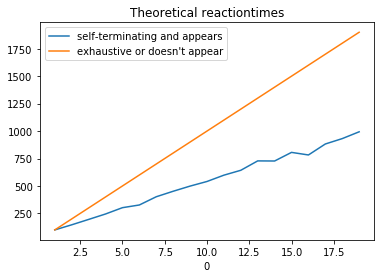

In [73]:
import random
per_number_time = 100
responsetimes = []
for appears in [True, False]:
    for seqlen in range(1,20):
        for _ in range(100):
            is_num = random.randint(1,seqlen)
            term_responsetime = per_number_time*is_num#*(is_num if appears else seqlen)
            nterm_responsetime = per_number_time*seqlen
            responsetimes.append((seqlen, term_responsetime, nterm_responsetime))

fig, ax = plt.subplots()
pd.DataFrame(responsetimes).groupby(0).mean().plot(ax=ax, title="Theoretical reactiontimes")
plt.legend(["self-terminating and appears", "exhaustive or doesn't appear"])

In [213]:
import pandas as pd
from expyriment import misc
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
NUM_STANDARD_DEVIATIONS = 2

In [214]:
data_folder = "subjdata/"
misc.data_preprocessing.write_concatenated_data(data_folder, "sternberg_task", output_file="data.csv")

** Expyriment Data Preprocessor **
found 81 subject_data sets
found 6 variables: [b'subject_id', b'Block', b'Length', b'Response Time', b'Does Appear', b'Correct Answer']
   reading b'sternberg_task_301.xpd'
   reading b'sternberg_task_105.xpd'
   reading b'sternberg_task_314.xpd'
   reading b'sternberg_task_310.xpd'
   reading b'sternberg_task_217.xpd'
   reading b'sternberg_task_209.xpd'
   reading b'sternberg_task_103.xpd'
   reading b'sternberg_task_107.xpd'
   reading b'sternberg_task_303.xpd'
   reading b'sternberg_task_223.xpd'
   reading b'sternberg_task_216.xpd'
   reading b'sternberg_task_320.xpd'
   reading b'sternberg_task_221.xpd'
   reading b'sternberg_task_318.xpd'
   reading b'sternberg_task_207.xpd'
   reading b'sternberg_task_117.xpd'
   reading b'sternberg_task_305.xpd'
   reading b'sternberg_task_130.xpd'
   reading b'sternberg_task_213.xpd'
   reading b'sternberg_task_302.xpd'
   reading b'sternberg_task_203.xpd'
   reading b'sternberg_task_205.xpd'
   reading b'st

In [237]:
df = pd.read_csv("data.csv", comment="#").sort_values(by="subject_id").dropna()
df = df.rename(mapper={"Does Appear": "does_appear", "Response Time": "response_time", "Correct Answer": "correct_answer"}, axis="columns")
df = df[df["response_time"] > 0]

In [238]:
accuracies = df.groupby("subject_id")["correct_answer"].mean()
print("Mean Accuracy by subject:", accuracies.mean(), "Std:", accuracies.std())
min_acc = accuracies.mean()-NUM_STANDARD_DEVIATIONS*accuracies.std()
print("Least Accuracy to be counted:", min_acc)
to_delete = list(accuracies[accuracies<min_acc].index)
print("Deleted will be:", to_delete)
df = df[~df["subject_id"].isin(to_delete)]
df = df[~(df["Block"] == "Practice")]
df = df[df["correct_answer"]].drop("correct_answer", axis="columns")

Mean Accuracy by subject: 0.9265085275005156 Std: 0.07319302943115578
Least Accuracy to be counted: 0.780122468638204
Deleted will be: [16, 114, 230, 312]


In [239]:
averaged_times = df.groupby(['subject_id', 'Length', 'does_appear']).mean().reset_index()
global_average = averaged_times.groupby(['Length', 'does_appear'])["response_time"].mean()
global_average.reset_index()

,Length,does_appear,response_time
0,1.0,False,698.049561
1,1.0,True,613.589401
2,2.0,False,726.968713
3,2.0,True,668.781015
4,3.0,False,751.286346
5,3.0,True,716.735062
6,4.0,False,792.903728
7,4.0,True,757.778206
8,5.0,False,844.597368
9,5.0,True,791.413200


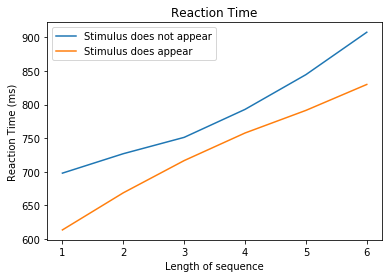

In [240]:
fig, ax = plt.subplots()
for num, obj in global_average.reset_index().groupby("does_appear"):
    obj.plot(x="Length", y="response_time", ax=ax, title="Reaction Time")

ax.legend(["Stimulus does not appear", "Stimulus does appear"])
ax.set(ylabel="Reaction Time (ms)", xlabel="Length of sequence")
plt.show()

We see that the reaction time increases with the number of items - this is already strong visual evidence that our working memory does not work in parallel.

In [241]:
fit = smf.ols('response_time ~ does_appear * Length', global_average.reset_index()).fit()
fit.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     154.0
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           2.05e-07
Time:                        12:04:16   Log-Likelihood:                -44.829
No. Observations:                  12   AIC:                             97.66
Df Residuals:                       8   BIC:                             99.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    642.6535     11.565     55.569      0.000     615.985     669.322
does_appear[T.True]          -62.0338     16.355     -3.793      0.005     -99.749     -24.318
Length                        41.2167      2.970     13.880      0.000      34.369      48.065
does_appear[T.True]:Length     1.3819      4.200      0.329      0.751      -8.303      11.066
==============================================================================
Omnibus:                        0.543   Durbin-Watson:                   2.951
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.543
Skew:                           0.128   Prob(JB):                        0.762
Kurtosis:                       1.990   Cond. No.                         24.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see: 
* The reaction time increases with the number of items (by 43ms on average, highly significant, p < 0.0001) $\rightarrow$ No parallel processing
* When the target does appear, the response time is on average 55 ms faster (highly significant, p<0.0001)
* We do not have an interaction-effect: does_appear[T.True]:Length is not significant
* With these two factors, we have 98.5% explained variance, which is quite a lot!

**$\Rightarrow$ Because the difference between conditions [appears/doesn't appear] is significant, we have to look at both groups separately!**

In [252]:
positives = global_average.reset_index()[global_average.reset_index()["does_appear"]]
negatives = global_average.reset_index()[~global_average.reset_index()["does_appear"]]

In [255]:
fit_pos = smf.ols('response_time ~ Length', positives).fit()
fit_pos.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     488.6
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           2.48e-05
Time:                        12:31:37   Log-Likelihood:                -19.820
No. Observations:                   6   AIC:                             43.64
Df Residuals:                       4   BIC:                             43.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    580.6196      7.505     77.360      0.000     559.781     601.458
Length        42.5986      1.927     22.104      0.000      37.248      47.949
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.101
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.569
Skew:                          -0.136   Prob(JB):                        0.752
Kurtosis:                       1.516   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [256]:
fit_neg = smf.ols('response_time ~ Length', negatives).fit()
fit_neg.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     122.0
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           0.000382
Time:                        12:31:42   Log-Likelihood:                -23.784
No. Observations:                   6   AIC:                             51.57
Df Residuals:                       4   BIC:                             51.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    642.6535     14.532     44.225      0.000     602.307     682.999
Length        41.2167      3.731     11.046      0.000      30.857      51.577
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.051
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.593
Skew:                           0.148   Prob(JB):                        0.743
Kurtosis:                       1.489   Cond. No.                         9.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* We explained 99% / 96.8% of the variance...
* There is almost no difference in the steepness of the curves

$\rightarrow$ If this difference was significant, it would provide evidence for serial & self-terminating recall. If not (if the same slope could explain both conditions equally), it would be evidence for serial & exhaustive.  
$\Rightarrow$ We have to see if this is significant

Let's plot the two opposing hypotheses - equal slope with different intercept vs. different slope:

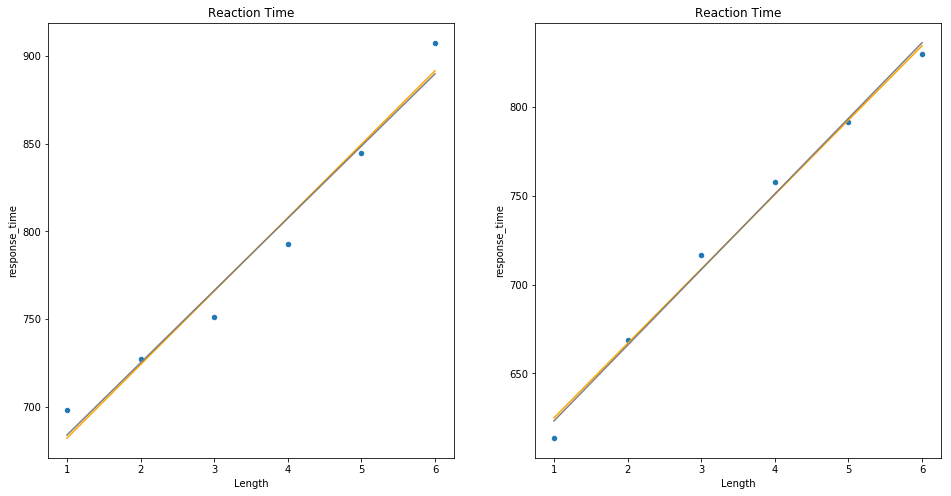

In [261]:
fit = smf.ols('response_time ~ does_appear + Length', global_average.reset_index()).fit()
fig, ax = plt.subplots(1, 2, figsize=(16,8))

for num, (cond, obj) in enumerate(global_average.reset_index().groupby("does_appear")):
    obj.plot(x="Length", y="response_time", ax=ax[num], title="Reaction Time", kind="scatter")
    joint_curve = fit.params["Intercept"]+fit.params["Length"]*np.arange(1,7) + (fit.params["does_appear[T.True]"] if cond else 0)
    ax[num].plot(np.arange(1,7), joint_curve, color="orange")    
       
ax[0].plot(np.arange(1,7), fit_neg.params["Intercept"]+fit_neg.params["Length"]*np.arange(1,7), color="grey")    
ax[1].plot(np.arange(1,7), fit_pos.params["Intercept"]+fit_pos.params["Length"]*np.arange(1,7), color="grey") 

What we have to do now, is to see if the difference of the entire curve is significant, or if it's simply for one condition. To do that, we have to look at the individual conditions (sequencelength = 1..6) separately, testing the difference for significance.  
We however have to *Bonferroni-Correct* the p-values:   
![https://xkcd.com/882/](xkcd_significant.png)

In [262]:
orig_alpha = 0.05
corr_alpha = orig_alpha/6
corr_alpha

0.008333333333333333

In [263]:
#doesntappear, doesappear = [[j[2] for j in obj[1].values] for obj in global_average.reset_index().groupby("does_appear")]

all_pos = []
all_neg = []
for cond, i in averaged_times.groupby(['Length', 'does_appear']):
    if cond[1]:
        all_pos.append(list(i["response_time"]))
    else:
        all_neg.append(list(i["response_time"]))
        
all_vals = all_pos + all_neg
labels = [True]*len(all_pos)+[False]*len(all_neg)

In [289]:
av2 = averaged_times.drop("subject_id", axis="columns")
av2.head()

,Length,does_appear,response_time
0,1.0,False,818.333333
1,1.0,True,839.222222
2,2.0,False,770.750000
3,2.0,True,655.833333
4,3.0,False,889.444444


In [291]:
import statsmodels.stats.multicomp as multi
for length in range(1,7):
    mc = multi.MultiComparison(av2[av2["Length"] == length]["response_time"], av2[av2["Length"] == length]["does_appear"])
    res = mc.tukeyhsd(alpha=corr_alpha)
    print(res.summary())
    print()

Multiple Comparison of Means - Tukey HSD,FWER=0.01
group1 group2 meandiff   lower    upper  reject
-----------------------------------------------
False   True  -84.4602 -179.0934 10.1731 False 
-----------------------------------------------

Multiple Comparison of Means - Tukey HSD,FWER=0.01
group1 group2 meandiff   lower    upper  reject
-----------------------------------------------
False   True  -58.1877 -161.4822 45.1068 False 
-----------------------------------------------

Multiple Comparison of Means - Tukey HSD,FWER=0.01
group1 group2 meandiff   lower    upper  reject
-----------------------------------------------
False   True  -34.5513 -129.9847 60.8821 False 
-----------------------------------------------

Multiple Comparison of Means - Tukey HSD,FWER=0.01
group1 group2 meandiff   lower    upper  reject
-----------------------------------------------
False   True  -35.1255 -139.3678 69.1167 False 
-----------------------------------------------

Multiple Comparison of M

* All differences are not significant. 

$\Rightarrow$ We do not search in parallel  
$\Rightarrow$ Because the curves's steepness does not differ significantly for the appears/doesn't appear condition, we assume that we search exhaustively.